In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
train['keyword'].unique().shape


(222,)

<AxesSubplot:>

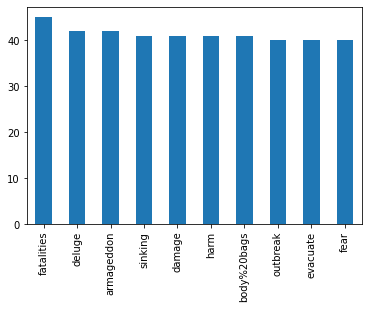

In [9]:
train['keyword'].value_counts().head(10).plot(kind='bar')

In [10]:
#sklean countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
bow=CountVectorizer(max_features=1000)
train_bow=bow.fit_transform(train['text'])
test_bow=bow.transform(test['text'])



In [4]:
#fill nan keyword with 0
train['keyword'].fillna('0',inplace=True)
test['keyword'].fillna('0',inplace=True)

#assign int to keyword
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
train['keyword_label']=label.fit_transform(train['keyword'])
test['keyword_label']=label.transform(test['keyword'])
#X- train_bow+ train['keyword_label']


In [5]:
keywords_train=train['keyword'].values
#concatenate


In [14]:
X_train=train_bow

In [15]:
#split train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_train,train['target'],test_size=0.2,random_state=42)
#

In [16]:
#logistic regression
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(max_iter=10000)
logreg.fit(x_train,y_train)
#score
logreg.score(x_test,y_test)

0.793827971109652

In [17]:
logreg.score(x_train,y_train)

0.8573070607553366

In [18]:
#prediction on test
pred=logreg.predict(test_bow)
#save prediction
pd.DataFrame({'id':test['id'],'target':pred}).to_csv('submission.csv',index=False)



In [14]:
!pip install tensorflow_text


In [3]:
#bert
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/2",
    trainable=False,)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 256].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 256].
#dense layer
dense=tf.keras.layers.Dense(1,activation='sigmoid')(pooled_output)
model=tf.keras.Model(inputs=text_input,outputs=dense)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [4]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5)
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
callbacks=[reduce_lr,early_stopping]


In [9]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [7]:
model.fit(train['text'],train['target'],batch_size=64,epochs=10,validation_split=0.2,callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - 19s 197ms/step - loss: 0.6516 - accuracy: 0.6130 - val_loss: 0.6091 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 2/10
96/96 [==============================] - 19s 200ms/step - loss: 0.5951 - accuracy: 0.6970 - val_loss: 0.5659 - val_accuracy: 0.7452 - lr: 0.0010
Epoch 3/10
96/96 [==============================] - 19s 200ms/step - loss: 0.5670 - accuracy: 0.7274 - val_loss: 0.5408 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 4/10
96/96 [==============================] - 19s 200ms/step - loss: 0.5496 - accuracy: 0.7381 - val_loss: 0.5263 - val_accuracy: 0.7498 - lr: 0.0010
Epoch 5/10
96/96 [==============================] - 19s 201ms/step - loss: 0.5373 - accuracy: 0.7432 - val_loss: 0.5182 - val_accuracy: 0.7689 - lr: 0.0010
Epoch 6/10
96/96 [==============================] - 19s 200ms/step - loss: 0.5281 - accuracy: 0.7473 - val_loss: 0.5135 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 7/10
96/96 [==============================] - 19s 200ms/st

In [6]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification 

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased",num_labels=2)
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=2)



/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 5.42MB/s]
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 16.3kB/s]
Downloading: 100%|██████████| 483/483 [00:00<00:00, 278kB/s]
Downloading: 100%|██████████| 347M/347M [00:06<00:00, 57.4MB/s] 
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This 

In [7]:
#tokenize
train_tokens = tokenizer(train.text.values.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=512)
test_tokens = tokenizer(test.text.values.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=512)

In [10]:
#select attention_mask and input_ids and token_type_ids
train_input_ids = train_tokens["input_ids"]
train_attention_mask = train_tokens["attention_mask"]
test_input_ids = test_tokens["input_ids"]
test_attention_mask = test_tokens["attention_mask"]
tr_token=tf.concat([train_input_ids,train_attention_mask],axis=1)
te_token=tf.concat([test_input_ids,test_attention_mask],axis=1)

In [11]:
train_labels=train.target.values
train_data=tf.data.Dataset.from_tensor_slices((tr_token,train_labels)).shuffle(len(train_labels)).batch(64)


In [ ]:
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=2)

optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(train_data,batch_size=64, epochs=5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_39', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
119/119 [==============================] - 126s 979ms/step - loss: 0.6992 - accuracy: 0.5529
Epoch 2/5
119/119 [==============================] - 121s 1s/step - loss: 0.6857 - accuracy: 0.5703
Epoch 3/5
119/119 [==============================] - 123s 1s/step - loss: 0.6844 - accuracy: 0.5706


In [ ]:
from transformers import AutoModel, AutoTokenizer,TFAutoModelForSequenceClassification ,AutoConfig


config = AutoConfig.from_pretrained("vinai/bertweet-base",num_labels=2)
berttweet = TFAutoModelForSequenceClassification.from_config(config)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",num_labels=2)




In [ ]:
train_tokens = tokenizer(train.text.values.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=512)
test_tokens = tokenizer(test.text.values.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=512)
#select attention_mask and input_ids and token_type_ids
train_input_ids = train_tokens["input_ids"]
train_attention_mask = train_tokens["attention_mask"]
test_input_ids = test_tokens["input_ids"]
test_attention_mask = test_tokens["attention_mask"]
tr_token=tf.concat([train_input_ids,train_attention_mask],axis=1)
te_token=tf.concat([test_input_ids,test_attention_mask],axis=1)
train_data=tf.data.Dataset.from_tensor_slices((tr_token,train_labels)).shuffle(len(train_labels)).batch(32)
    

In [ ]:
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4)
berttweet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
berttweet.fit(train_data,batch_size=32, epochs=5)